#### 0. Prepare Pkgs

In [1]:
from warnings import simplefilter
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from scipy.signal import periodogram
from sklearn.model_selection import train_test_split
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.deterministic import DeterministicProcess, CalendarFourier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error


simplefilter('ignore')

In [2]:
plt.style.use('seaborn-whitegrid')
plt.rc('figure', autolayout = True,
      figsize = (11,4))
plt.rc(
    'axes',
    labelweight = 'bold',
    labelsize = 'large',
    titleweight = 'bold',
    titlesize = 14,
    titlepad = 10,
)
plot_params = dict(
    color = '.75',
    style = '.-',
    markeredgecolor = '.25',
    markerfacecolor = '.25',
    legend = False,
)
%config InlineBackend.figure_format = 'retina'

In [3]:
tunnel = pd.read_csv('Documents/tunnel.csv', 
                     parse_dates=['Day'],
                     index_col = 'Day')
tunnel = tunnel.to_period()
tunnel.head()

,NumVehicles
Day,
2003-11-01,103536
2003-11-02,92051
2003-11-03,100795
2003-11-04,102352
2003-11-05,106569


#### 1. Linear Regression with Time Series

In [5]:
df = tunnel.copy()
df['Time'] = np.arange(len(tunnel.index))

Text(0.5, 1.0, 'Time Plot of Tunnel Traffic')

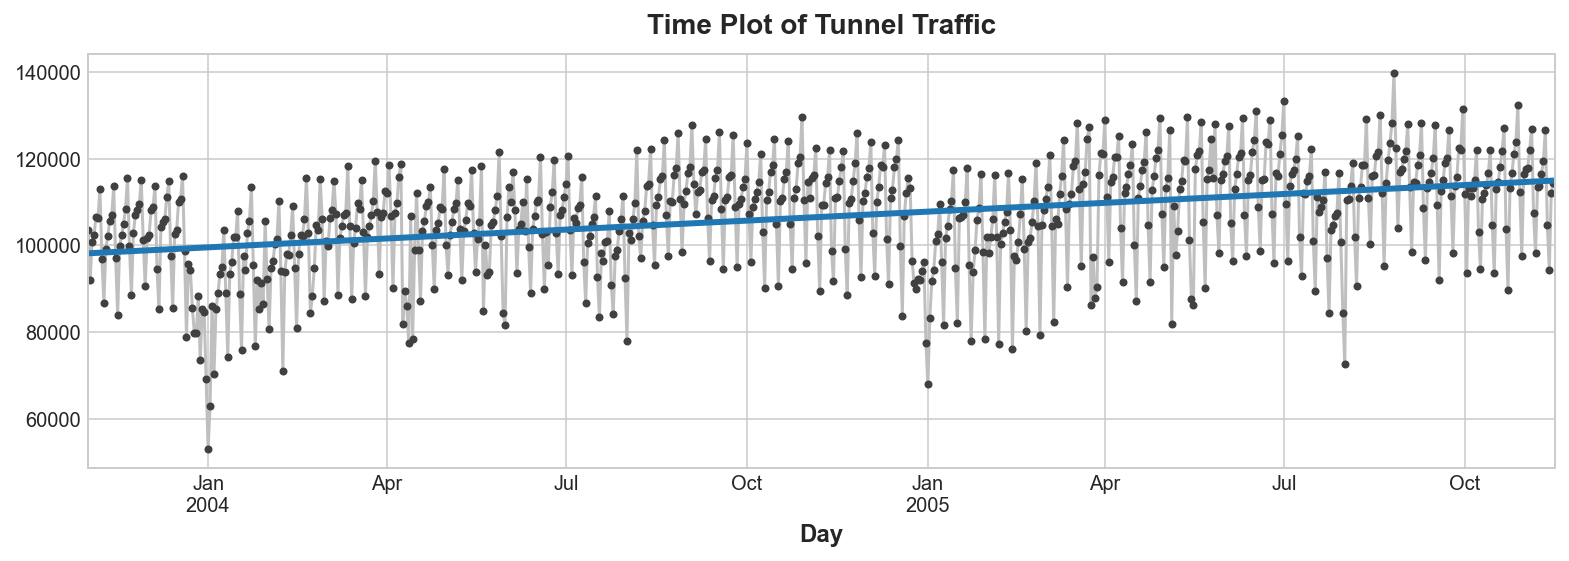

In [6]:
X = df.loc[:,['Time']]
y = df.loc[:,'NumVehicles']

# fit the model and plot preds against reals
model = LinearRegression()
model.fit(X, y)
y_pred = pd.Series(model.predict(X), index = X.index)

ax = y.plot(**plot_params)
ax = y_pred.plot(ax = ax, linewidth = 3)
ax.set_title('Time Plot of Tunnel Traffic')

Text(0.5, 1.0, 'Lag Plot of Tunnel Traffic')

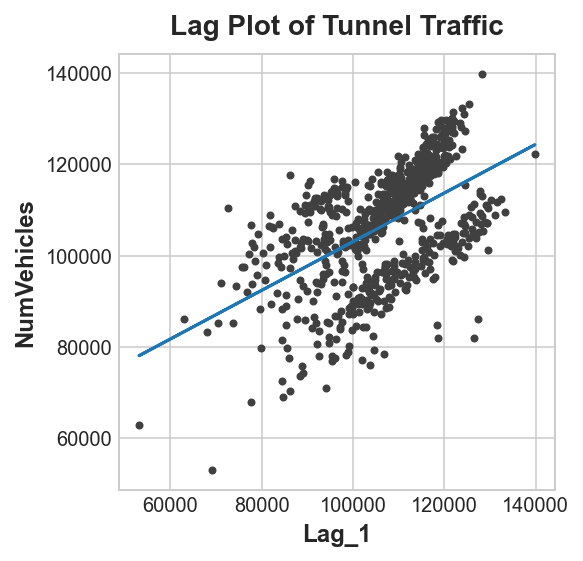

In [6]:
# Lag plot
df['Lag_1'] = df.NumVehicles.shift(1)

X = df.loc[:,['Lag_1']]
X.dropna(inplace =True)
y = df.loc[:,'NumVehicles']
y, X = y.align(X, join = 'inner') # drop NaNs

model = LinearRegression()
model.fit(X, y)

y_pred = pd.Series(model.predict(X), index = X.index)

fig, ax = plt.subplots()
ax.plot(X['Lag_1'], y, '.', color = '.25')
ax.plot(X['Lag_1'], y_pred)
ax.set_aspect('equal')
ax.set_ylabel('NumVehicles')
ax.set_xlabel('Lag_1')
ax.set_title('Lag Plot of Tunnel Traffic')

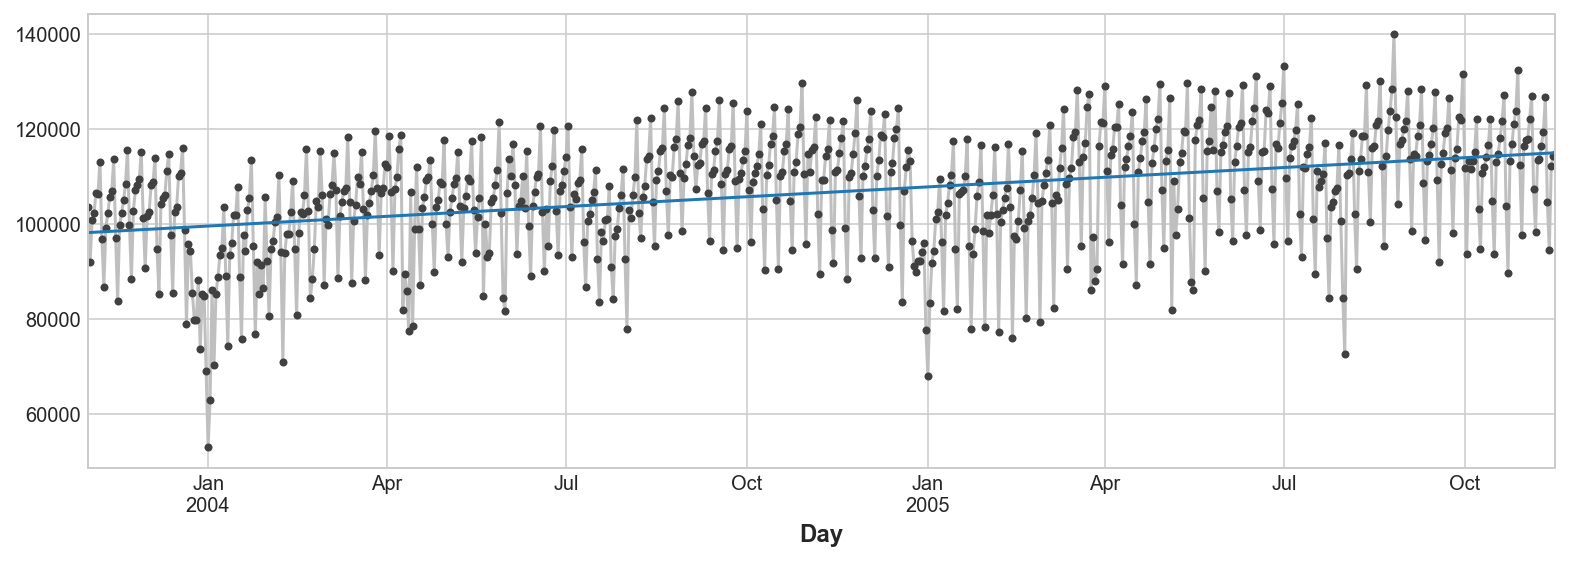

In [7]:
ax = y.plot(**plot_params)
ax = y_pred.plot()

#### 2. Trend

In [8]:
from statsmodels.tsa.deterministic import DeterministicProcess

<AxesSubplot:title={'center':'Tunnel Traffic - 365-Day Moving Average'}, xlabel='Day'>

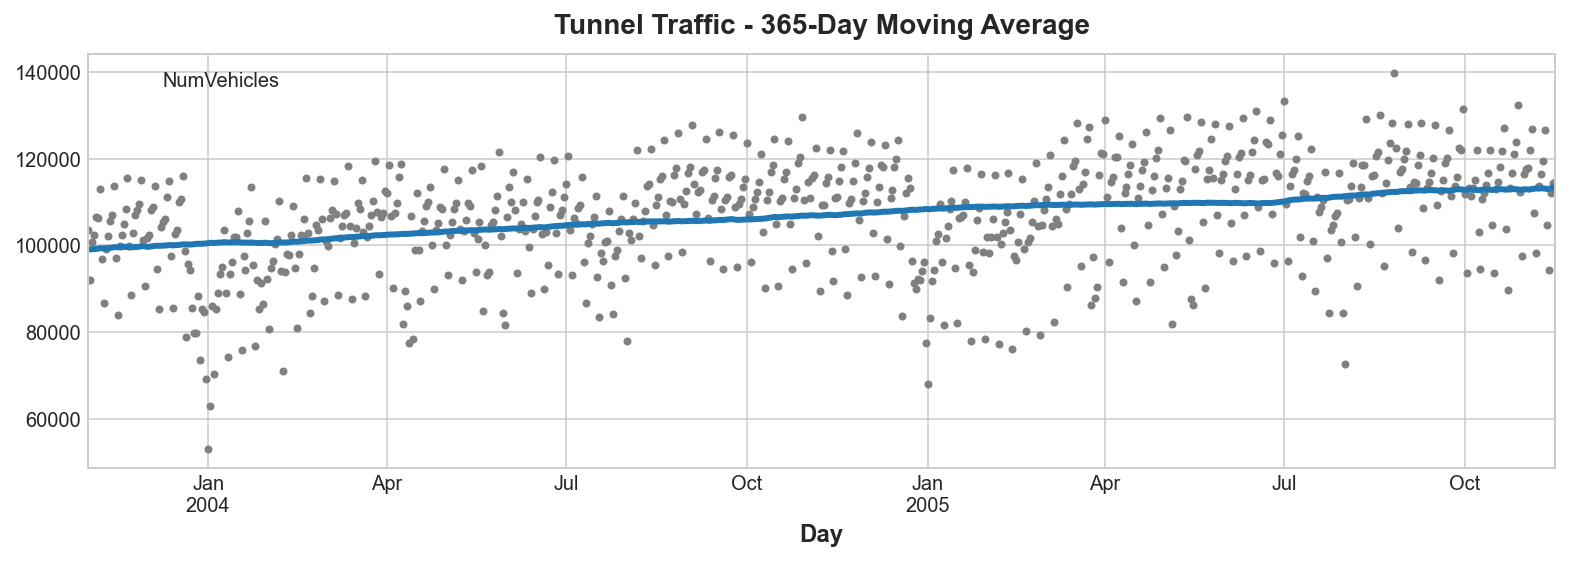

In [9]:
# Moving Average Plot to see shape of trend excluding seasonality
moving_avg = tunnel.rolling(
    window = 365,
    center = True, # puts the average at the center of the window
    min_periods = 183, # ~ half the window size
    ).mean() # median(), std(), min(), max()

ax = tunnel.plot(style = '.', color = '.5')
moving_avg.plot(
    ax = ax, linewidth = 3, title = 'Tunnel Traffic - 365-Day Moving Average',
    legend = False,)

In [10]:
dp = DeterministicProcess(
    index = tunnel.index,
    constant = True, # dummy feature for the bias
    order = 1, # level of linearity
    drop = True, # drop terms if necessary in case of collinearity
) # Features derived from the time index generally be *deterministic* (1/2)
X = dp.in_sample()

X.head() # (2/2) like const & trend

,const,trend
Day,,
2003-11-01,1.0,1.0
2003-11-02,1.0,2.0
2003-11-03,1.0,3.0
2003-11-04,1.0,4.0
2003-11-05,1.0,5.0


In [11]:
y = tunnel.NumVehicles

model = LinearRegression(fit_intercept=False) # intercept is the same as const in DP, 
# linear regression behaves badly with duplicated features, so False
model.fit(X,y)
y_pred = pd.Series(model.predict(X), index=X.index)

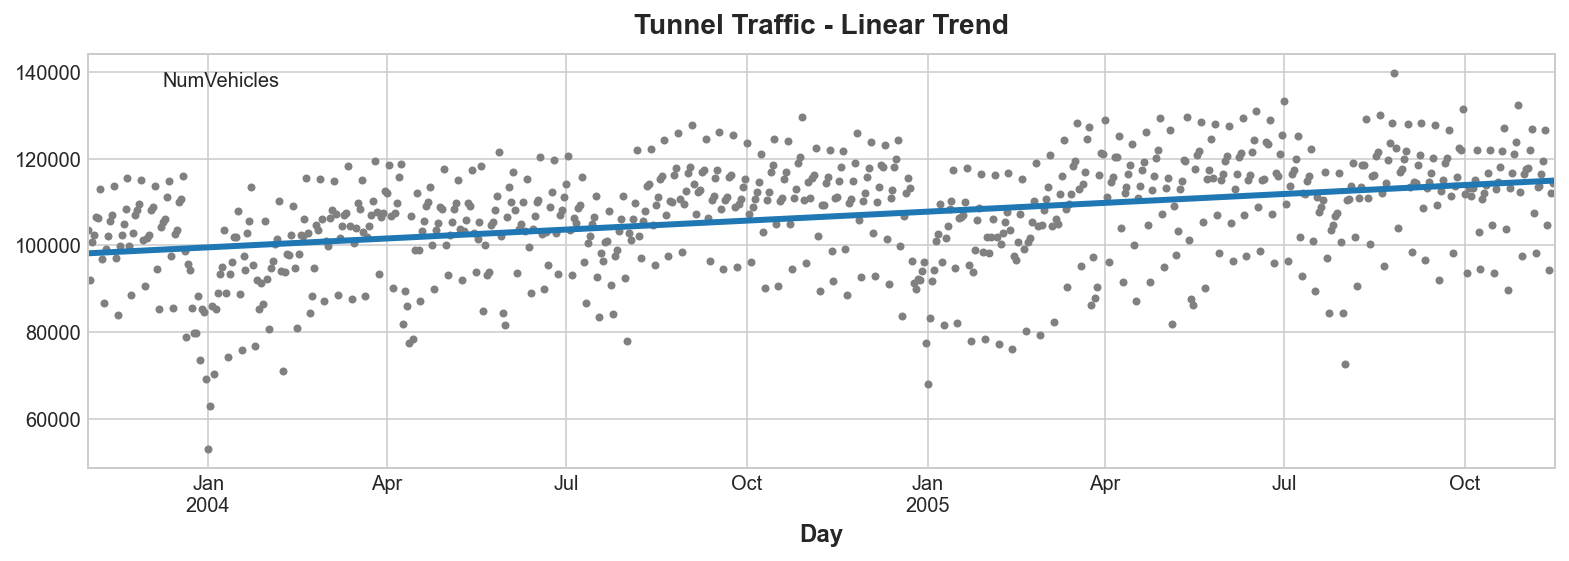

In [12]:
ax = tunnel.plot(style = '.', color = '.5', title =
                'Tunnel Traffic - Linear Trend')
_ = y_pred.plot(ax = ax, linewidth = 3, label = 'Trend')

In [13]:
X = dp.out_of_sample(steps = 30)
y_fore = pd.Series(model.predict(X),index = X.index)
y_fore.head()

2005-11-17    114981.801146
2005-11-18    115004.298595
2005-11-19    115026.796045
2005-11-20    115049.293494
2005-11-21    115071.790944
Freq: D, dtype: float64

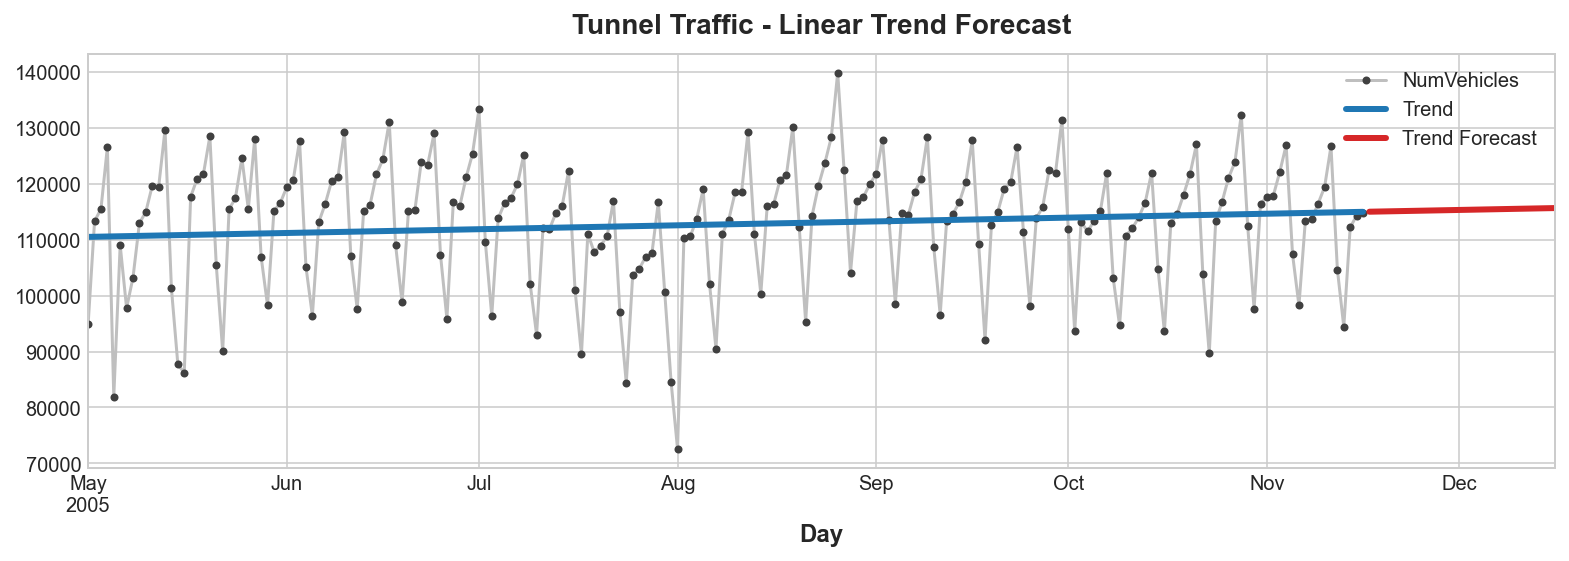

In [14]:
ax = tunnel["2005-05":].plot(title = 'Tunnel Traffic - Linear Trend Forecast',
                            **plot_params)
ax = y_pred["2005-05":].plot(ax = ax, linewidth = 3, label = 'Trend')
ax = y_fore.plot(ax = ax, linewidth = 3,
                label = 'Trend Forecast',
                color = 'C3')
_ = ax.legend()

#### 3. Seasonality

In [15]:
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess

def seasonal_plot(X, y, period, freq, ax=None):
    if ax is None:
        _, ax = plt.subplots()
    palette = sns.color_palette("husl", n_colors=X[period].nunique(),)
    ax = sns.lineplot(
        x=freq,
        y=y,
        hue=period,
        data=X,
        ci=False,
        ax=ax,
        palette=palette,
        legend=False,
    )
    ax.set_title(f"Seasonal Plot ({period}/{freq})")
    for line, name in zip(ax.lines, X[period].unique()):
        y_ = line.get_ydata()[-1]
        ax.annotate(
            name,
            xy=(1, y_), # point (x,y)
            xytext=(6, 0), # posit
            color=line.get_color(),
            xycoords=ax.get_yaxis_transform(), # coord according to y-axis
            textcoords="offset points",
            size=14,
            va="center",
        )
    return ax

In [16]:
def plot_periodogram(ts, detrend = 'linear', ax = None):
    from scipy.signal import periodogram
    fs = pd.Timedelta('1Y')/pd.Timedelta('1D') # days in one year as ratio of 
    # duration-of-year and duration-of-day
    frequencies, spectrum = periodogram(
        ts,
        fs = fs,
        detrend = detrend,
        window = 'boxcar',
        scaling = 'spectrum',
    )
    if ax is None:
        _, ax = plt.subplots()
    ax.step(frequencies, spectrum, color = 'purple')
    # plot as steps
    ax.set_xscale('log')
    ax.set_xticks([1, 2, 4, 6, 12, 26, 52, 104])
    ax.set_xticklabels(
        [
                "Annual (1)",
                "Semiannual (2)",
                "Quarterly (4)",
                "Bimonthly (6)",
                "Monthly (12)",
                "Biweekly (26)",
                "Weekly (52)",
                "Semiweekly (104)"
        ],
    rotation = 30,
    )
    ax.ticklabel_format(axis ='y', style ='sci',
                       scilimits = (0,0))
    ax.set_ylabel('Variance')
    ax.set_title('Periodogram')
    return ax 

<AxesSubplot:title={'center':'Seasonal Plot (year/dayofyear)'}, xlabel='dayofyear', ylabel='NumVehicles'>

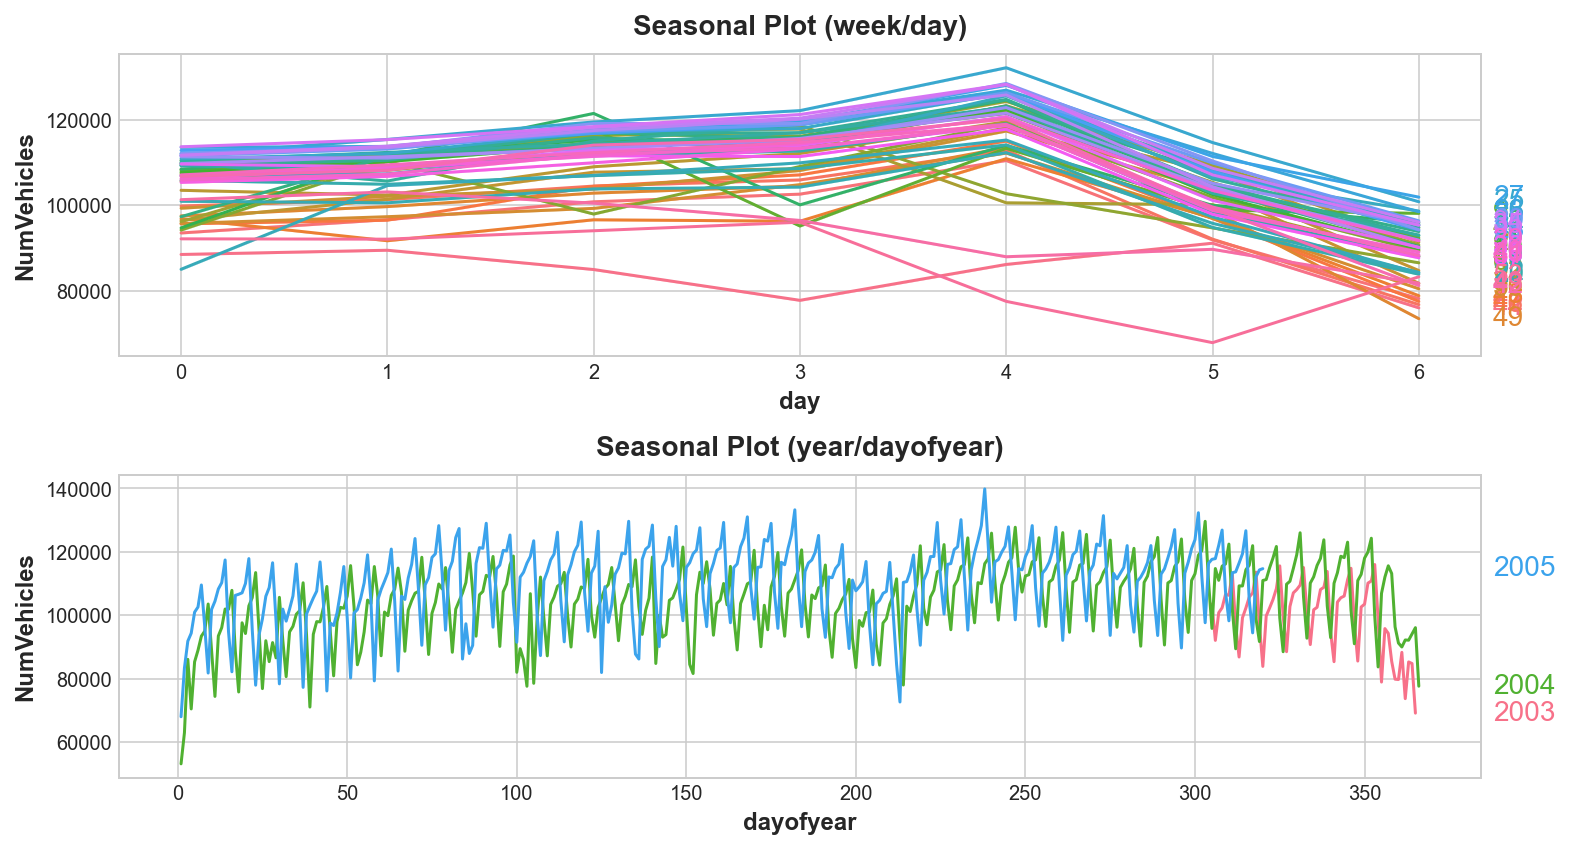

In [17]:
X = tunnel.copy()

# days within a week
X['day'] = X.index.dayofweek # because period object
X['week'] = X.index.week

# days within a year
X['dayofyear'] = X.index.dayofyear
X['year'] = X.index.year

fig, (ax0, ax1) = plt.subplots(2, 1, figsize = (11,6))
seasonal_plot(X, y = 'NumVehicles', period = 'week', 
              freq = 'day', ax= ax0)
seasonal_plot(X, y = 'NumVehicles', period = 'year', 
             freq = 'dayofyear', ax = ax1)

<AxesSubplot:title={'center':'Periodogram'}, ylabel='Variance'>

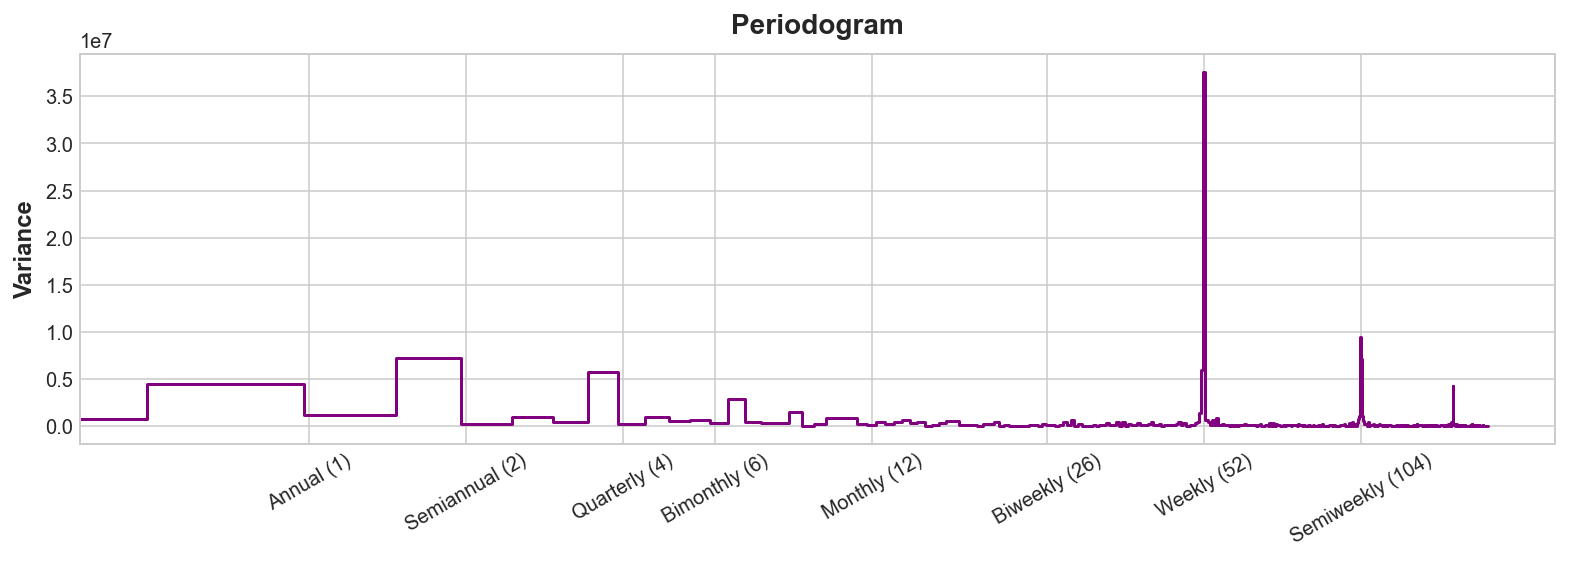

In [18]:
plot_periodogram(tunnel.NumVehicles)
# 10 Fourier pairs since fall off between 6 - 12 ?

In [19]:
fourier = CalendarFourier(freq = 'A', order = 10)
# 10 sin/cos pairs for Annual seasonality

dp = DeterministicProcess(
    index = tunnel.index,
    constant = True,
    order = 1,
    seasonal = True, # weekly seasonality (indicator)
    additional_terms = [fourier], # annual seasonality (fourier)
    drop = True,
)

X = dp.in_sample()

In [20]:
X.head()

,const,trend,"s(2,7)","s(3,7)","s(4,7)","s(5,7)","s(6,7)","s(7,7)","sin(1,freq=A-DEC)","cos(1,freq=A-DEC)",...,"sin(6,freq=A-DEC)","cos(6,freq=A-DEC)","sin(7,freq=A-DEC)","cos(7,freq=A-DEC)","sin(8,freq=A-DEC)","cos(8,freq=A-DEC)","sin(9,freq=A-DEC)","cos(9,freq=A-DEC)","sin(10,freq=A-DEC)","cos(10,freq=A-DEC)"
Day,,,,,,,,,,,,,,,,,,,,,
2003-11-01,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.867456,0.497513,...,-0.017213,0.999852,-0.875892,0.482508,-0.854322,-0.519744,0.025818,-0.999667,0.880012,-0.474951
2003-11-02,1.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,-0.858764,0.512371,...,0.085965,0.996298,-0.811539,0.584298,-0.917584,-0.397543,-0.128748,-0.991677,0.785650,-0.618671
2003-11-03,1.0,3.0,0.0,1.0,0.0,0.0,0.0,0.0,-0.849817,0.527078,...,0.188227,0.982126,-0.735417,0.677615,-0.963471,-0.267814,-0.280231,-0.959933,0.668064,-0.744104
2003-11-04,1.0,4.0,0.0,0.0,1.0,0.0,0.0,0.0,-0.840618,0.541628,...,0.288482,0.957485,-0.648630,0.761104,-0.991114,-0.133015,-0.425000,-0.905193,0.530730,-0.847541
2003-11-05,1.0,5.0,0.0,0.0,0.0,1.0,0.0,0.0,-0.831171,0.556017,...,0.385663,0.922640,-0.552435,0.833556,-0.999991,0.004304,-0.559589,-0.828770,0.377708,-0.925925


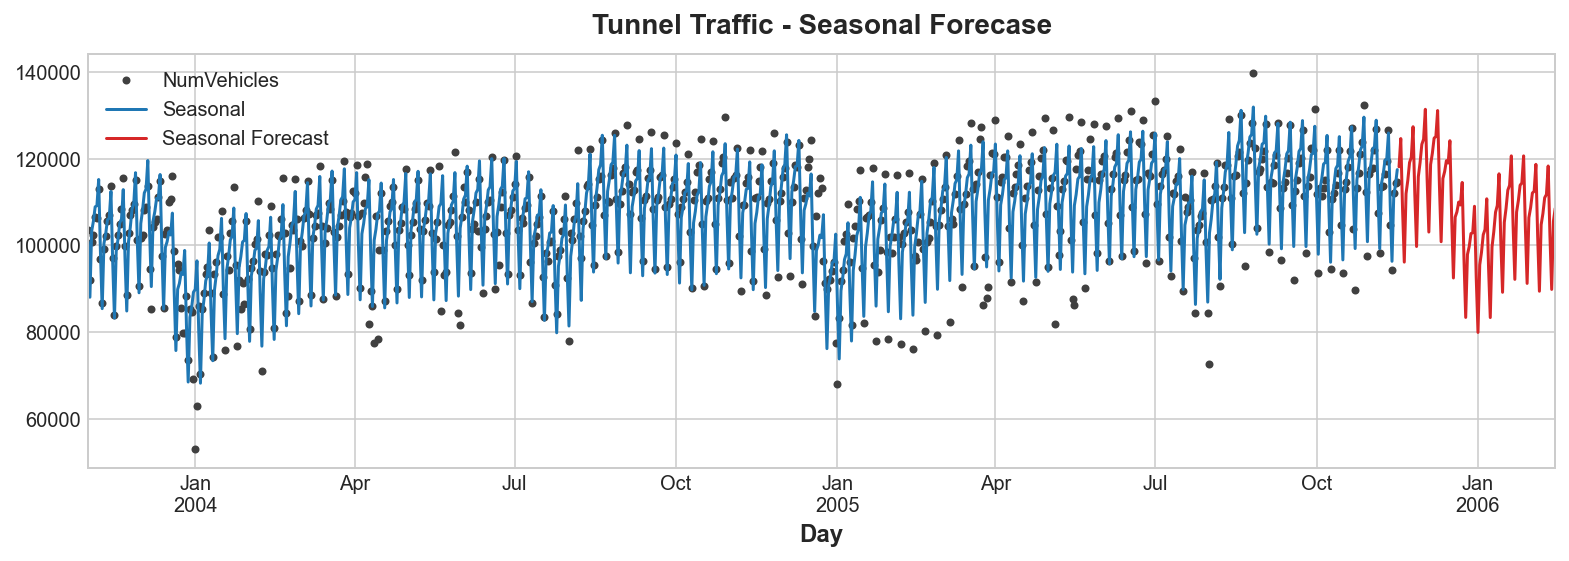

In [21]:
y = tunnel.NumVehicles

model = LinearRegression(fit_intercept = False)
_ = model.fit(X, y)

y_pred = pd.Series(model.predict(X), index = y.index)
X_fore = dp.out_of_sample(steps = 90)
y_fore = pd.Series(model.predict(X_fore), index = 
                  X_fore.index)

ax = y.plot(color = '.25', style = '.', title = 
           'Tunnel Traffic - Seasonal Forecase')
ax = y_pred.plot(ax = ax, label = 'Seasonal')
ax = y_fore.plot(ax = ax, label = 'Seasonal Forecast',
                color = 'C3')
_ = ax.legend()

###### <font color = '#909090'>remaining seasonality - holidays </font>

In [22]:
holiday_events= pd.read_csv('Documents/holidays_events.csv',
                           dtype = {
                               'type':'category',
                               'locale':'category',
                               'locale_name':'category',
                               'description':'category',
                               'transferred':'bool',
                           },
                           parse_dates = ['date'],
                           infer_datetime_format = True,
                           )

holiday_events = holiday_events.set_index('date').to_period('D')
# shift dates of holidays for convenience
# because I do not want to load a csv half a G
holiday_events.index = (holiday_events.index.to_timestamp() 
                - pd.DateOffset(years = 13)).to_period('D')

# query
holidays = (holiday_events
 .query("locale in ['National','Regional']")
 .loc['2004':'2004-08-15',['description']])

In [23]:
holidays

,description
date,
2004-01-01,Primer dia del ano
2004-01-02,Traslado Primer dia del ano
2004-02-27,Carnaval
2004-02-28,Carnaval
2004-04-01,Provincializacion de Cotopaxi
2004-04-14,Viernes Santo
2004-05-01,Dia del Trabajo
2004-05-13,Dia de la Madre-1
2004-05-14,Dia de la Madre


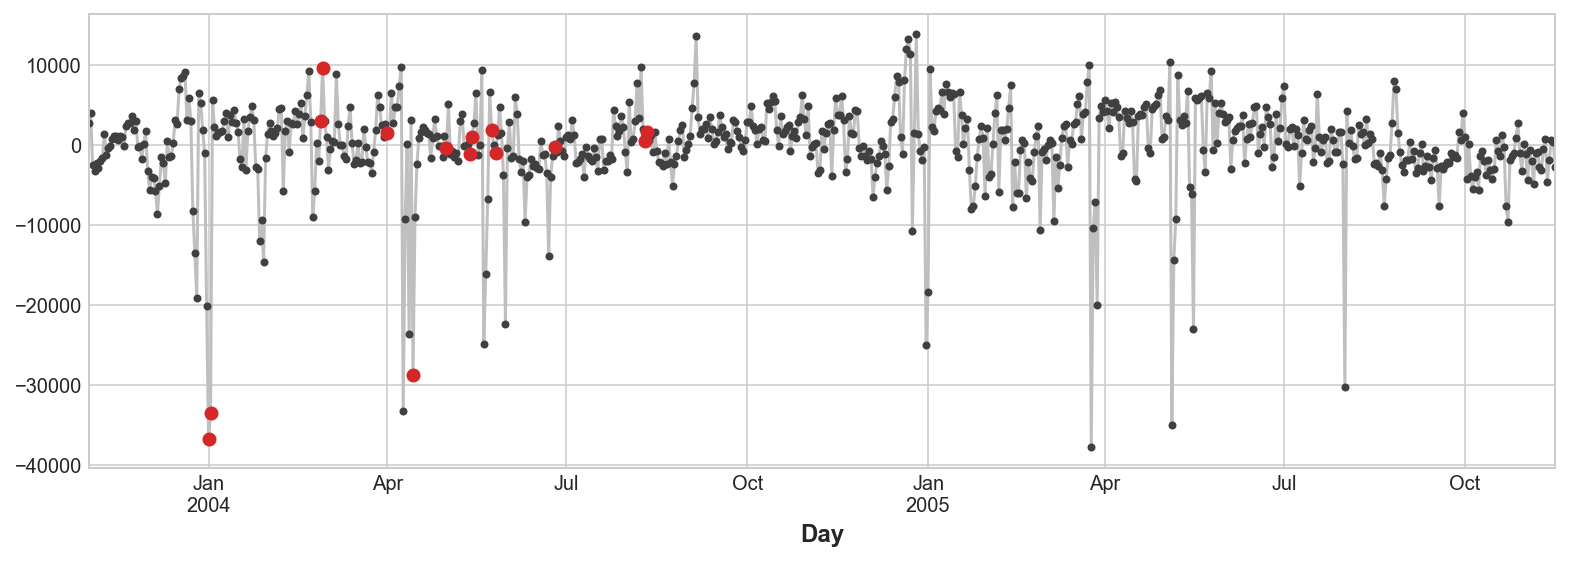

In [24]:
y_deseason = y - y_pred

ax = y_deseason.plot(**plot_params)
plt.plot_date(holidays.index, 
             y_deseason[holidays.index],
             color = 'C3')

In [25]:
X_holidays = pd.get_dummies(holidays)

# or use sklearn.preprocessing.OneHotEncoder
# ohe = OneHotEncoder(sparse = False)
# X_holidays = pd.DataFrame(ohe.fit_transfrom(holidays),
#                          index = holidays.index,
#                          columns = holidays.description.unique(),
#                          )


# rename index to match X
holidays.index.names = ['Day']
X2 = X.join(X_holidays, on = 'Day').fillna(0.0)
X2.head()

,const,trend,"s(2,7)","s(3,7)","s(4,7)","s(5,7)","s(6,7)","s(7,7)","sin(1,freq=A-DEC)","cos(1,freq=A-DEC)",...,description_Terremoto Manabi+7,description_Terremoto Manabi+8,description_Terremoto Manabi+9,description_Traslado Batalla de Pichincha,description_Traslado Fundacion de Guayaquil,description_Traslado Fundacion de Quito,description_Traslado Independencia de Guayaquil,description_Traslado Primer Grito de Independencia,description_Traslado Primer dia del ano,description_Viernes Santo
Day,,,,,,,,,,,,,,,,,,,,,
2003-11-01,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.867456,0.497513,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2003-11-02,1.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,-0.858764,0.512371,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2003-11-03,1.0,3.0,0.0,1.0,0.0,0.0,0.0,0.0,-0.849817,0.527078,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2003-11-04,1.0,4.0,0.0,0.0,1.0,0.0,0.0,0.0,-0.840618,0.541628,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2003-11-05,1.0,5.0,0.0,0.0,0.0,1.0,0.0,0.0,-0.831171,0.556017,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


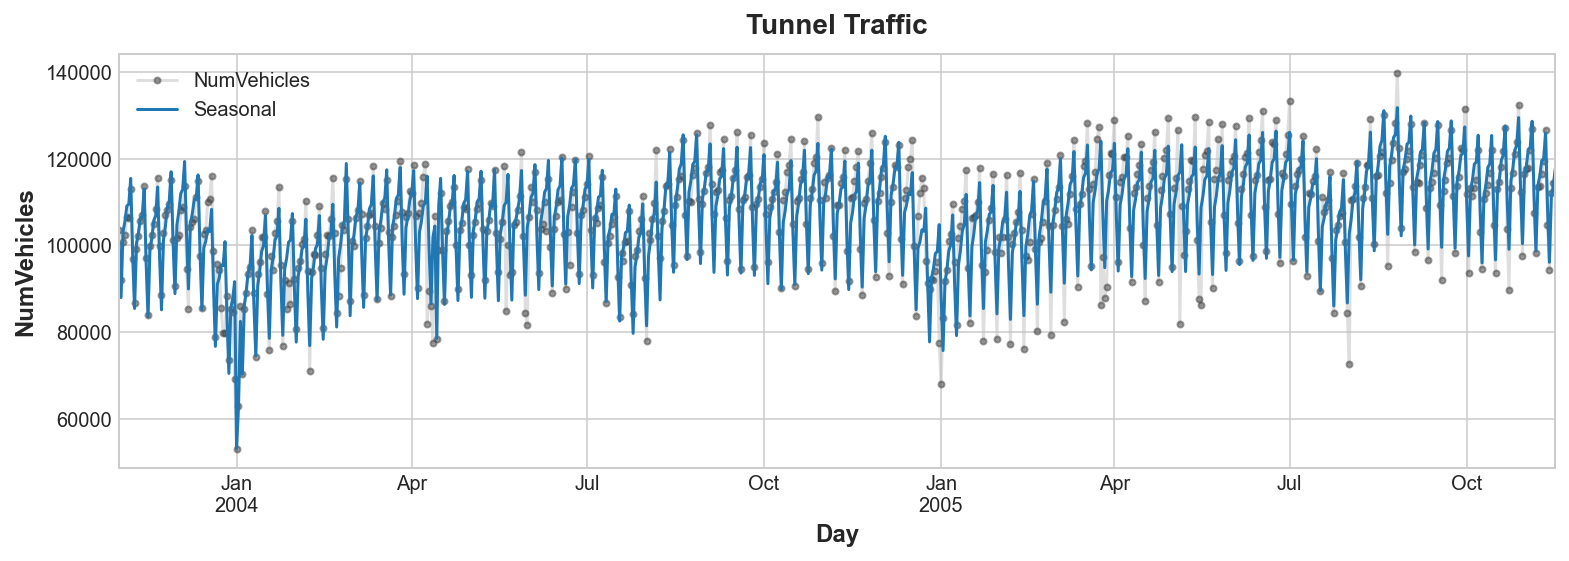

In [26]:
model = LinearRegression().fit(X2, y)
y_pred = pd.Series(
    model.predict(X2),
    index = X2.index,
    name = 'Fitted',
)

ax = y.plot(**plot_params, alpha = .5, 
           title = 'Tunnel Traffic',
           ylabel = 'NumVehicles')
ax = y_pred.plot(ax =ax, label = 'Seasonal')
ax.legend()

#### 4. Time Series as Features

In [22]:
# to show degree of linearity
def lagplot(x, y=None, lag=1, standardize=False, ax=None, **kwargs):
    from matplotlib.offsetbox import AnchoredText
    x_ = x.shift(lag)
    if standardize:
        x_ = (x_ - x_.mean()) / x_.std()
    if y is not None:
        y_ = (y - y.mean()) / y.std() if standardize else y
    else:
        y_ = x
    corr = y_.corr(x_)
    if ax is None:
        fig, ax = plt.subplots()
    scatter_kws = dict(
        alpha=0.75,
        s=3,
    )
    line_kws = dict(color='C3', )
    ax = sns.regplot(x=x_,
                     y=y_,
                     scatter_kws=scatter_kws,
                     line_kws=line_kws,
                     lowess=True,
                     ax=ax,
                     **kwargs)
    at = AnchoredText(
        f"{corr:.2f}",
        prop=dict(size="large"),
        frameon=True,
        loc="upper left",
    )
    at.patch.set_boxstyle("square, pad=0.0")
    ax.add_artist(at)
    ax.set(title=f"Lag {lag}", xlabel=x_.name, ylabel=y_.name)
    return ax


def plot_lags(x, y=None, lags=6, nrows=1, lagplot_kwargs={}, **kwargs):
    import math
    kwargs.setdefault('nrows', nrows)
    kwargs.setdefault('ncols', math.ceil(lags / nrows))
    kwargs.setdefault('figsize', (kwargs['ncols'] * 2, nrows * 2 + 0.5))
    fig, axs = plt.subplots(sharex=True, sharey=True, squeeze=False, **kwargs)
    for ax, k in zip(fig.get_axes(), range(kwargs['nrows'] * kwargs['ncols'])):
        if k + 1 <= lags:
            ax = lagplot(x, y, lag=k + 1, ax=ax, **lagplot_kwargs)
            ax.set_title(f"Lag {k + 1}", fontdict=dict(fontsize=14))
            ax.set(xlabel="", ylabel="")
        else:
            ax.axis('off')
    plt.setp(axs[-1, :], xlabel=x.name)
    plt.setp(axs[:, 0], ylabel=y.name if y is not None else x.name)
    fig.tight_layout(w_pad=0.1, h_pad=0.1)
    return fig

In [23]:
flu_trends = pd.read_csv('Documents/flu-trends.csv')
flu_trends.set_index(
    pd.PeriodIndex(flu_trends.Week, freq = 'W'),
    inplace = True,
)
flu_trends.drop('Week', axis = 1, inplace= True)

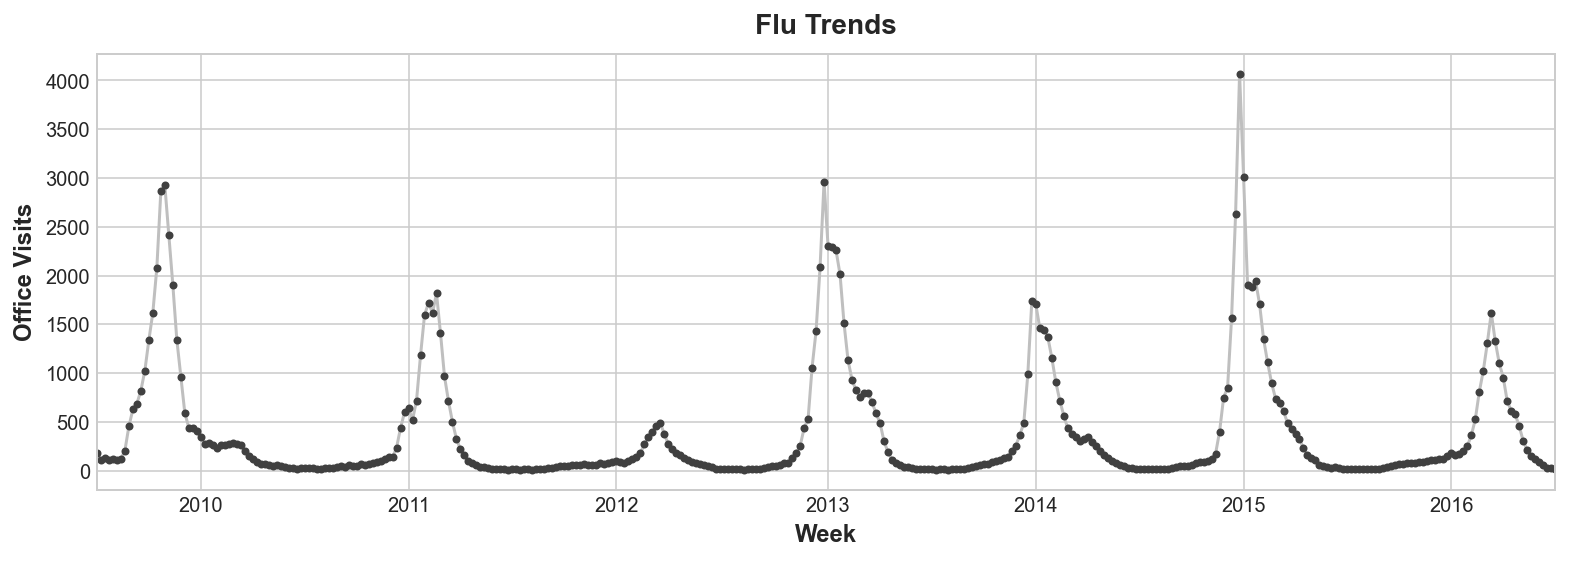

In [24]:
ax = flu_trends.FluVisits.plot(title = 'Flu Trends',
                              **plot_params)
_ = ax.set(ylabel = 'Office Visits')

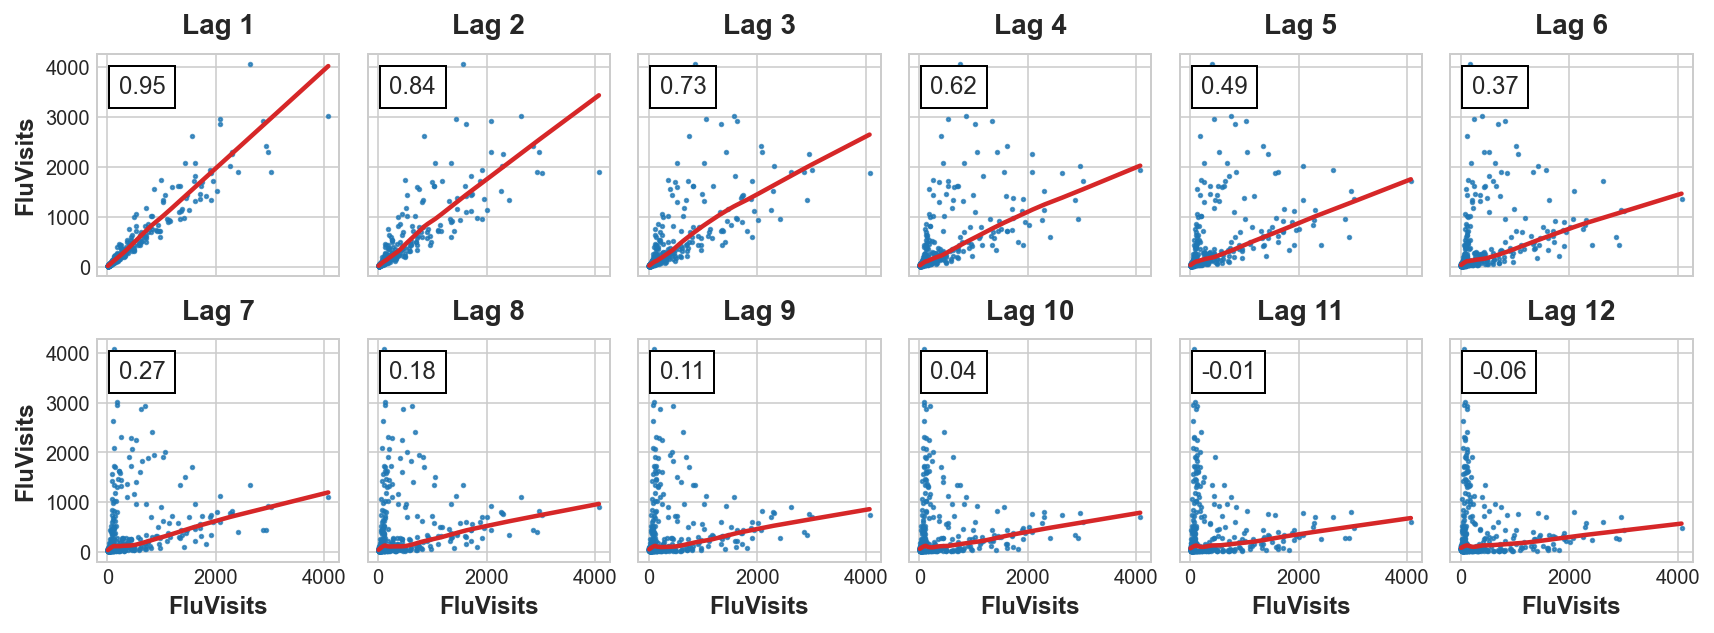

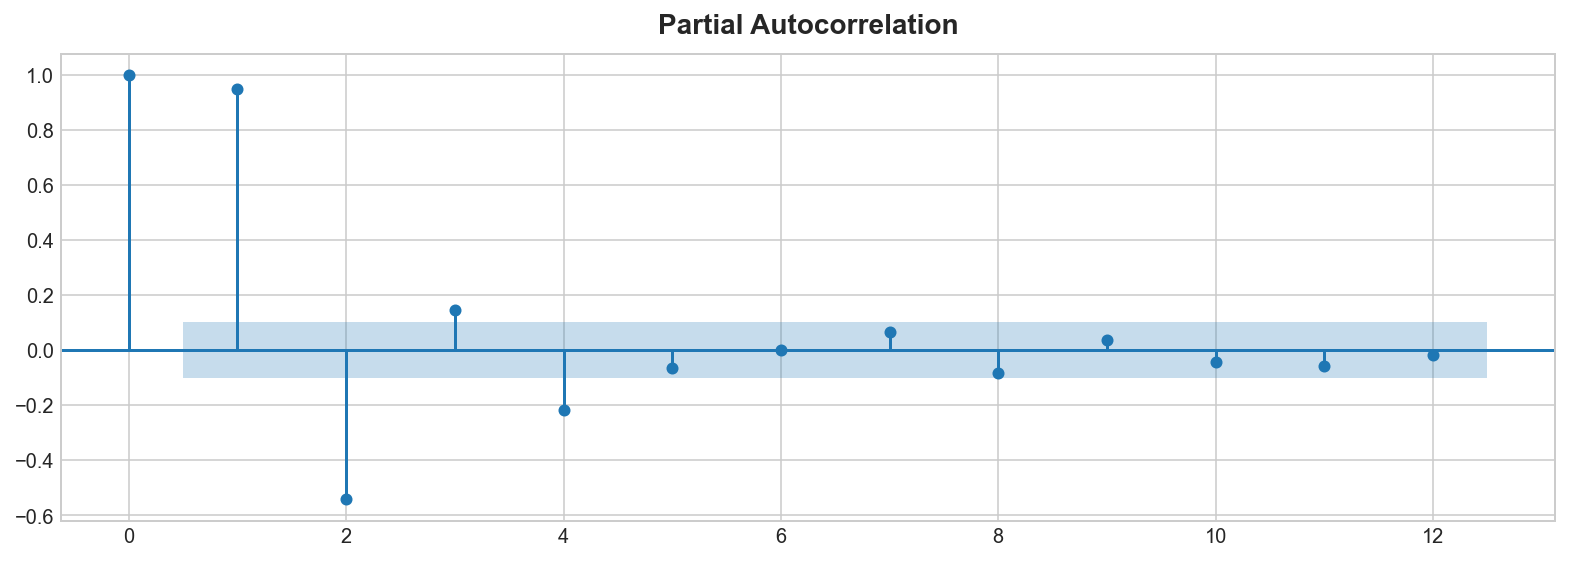

In [25]:
_ = plot_lags(flu_trends.FluVisits, lags = 12, nrows =  2)
_ = plot_pacf(flu_trends.FluVisits, lags = 12)
# 4 lags in partial autocorrelation plot

In [26]:
def make_lags(ts, lags):
    return pd.concat(
    {
        f'y_lag_{i}':ts.shift(i)
        for i in range(1, lags + 1)
    }, 
        # target should be lagged one step to avoid lookahead leakage
    axis = 1)

X = make_lags(flu_trends.FluVisits, lags = 4)
X = X.fillna(0.0)

In [27]:
y = flu_trends.FluVisits.copy()

###### <font color = '#909090'>Beginning of Add Leading Indicators</font>

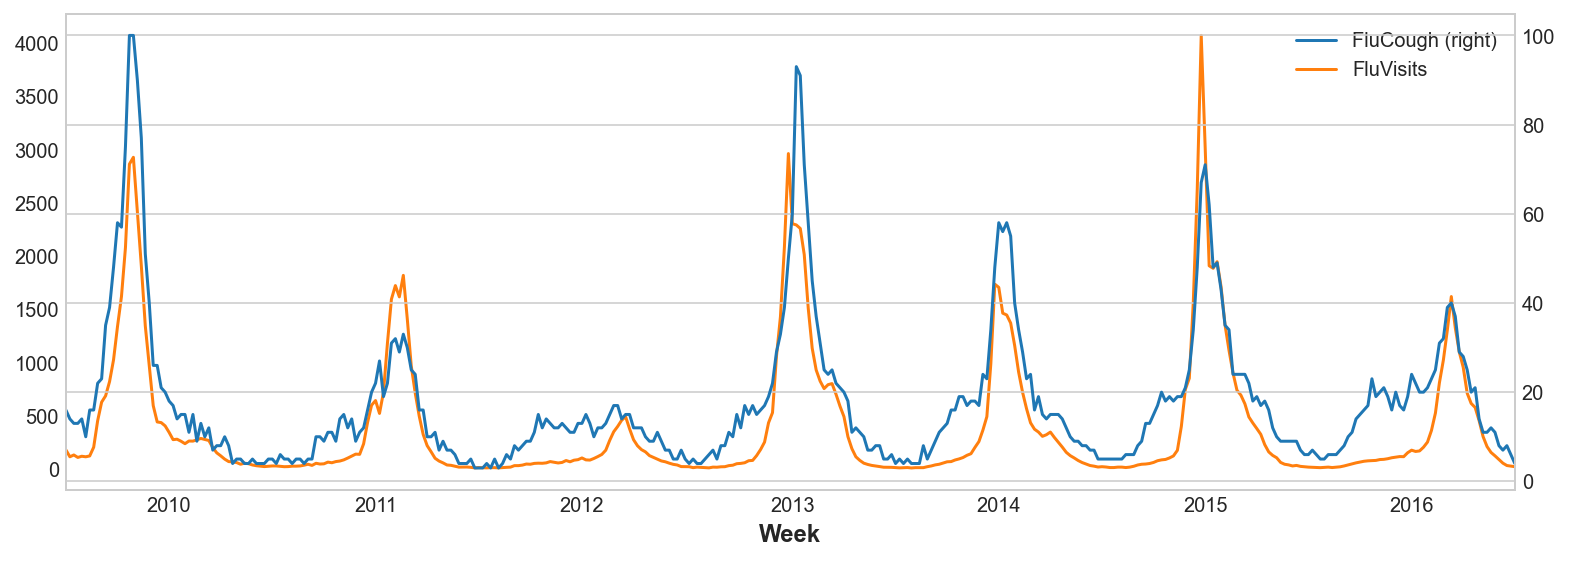

In [28]:
# introduce Leading Indicators: 
# "early warning" for changes in flu cases
ax = flu_trends.plot(
    y = ['FluCough', 'FluVisits'],
    secondary_y = 'FluCough',
)

In [29]:
search_terms = ["FluContagious", "FluCough", "FluFever", "InfluenzaA", "TreatFlu", "IHaveTheFlu", "OverTheCounterFlu", "HowLongFlu"]
X0 = make_lags(flu_trends[search_terms], lags = 3)
X1 = make_lags(flu_trends['FluVisits'], lags = 4)
X = pd.concat([X0, X1], axis = 1).fillna(0.0)

###### <font color = '#909090'>End of Add Leading Indicators</font>

In [30]:
X_train, X_test, y_train, y_test = train_test_split(
X, y, test_size = 60, shuffle = False)
model = LinearRegression()  
model.fit(X_train, y_train)
y_pred = pd.Series(model.predict(X_train), index =
                   y_train.index)
y_fore = pd.Series(model.predict(X_test), index = y_test.index)

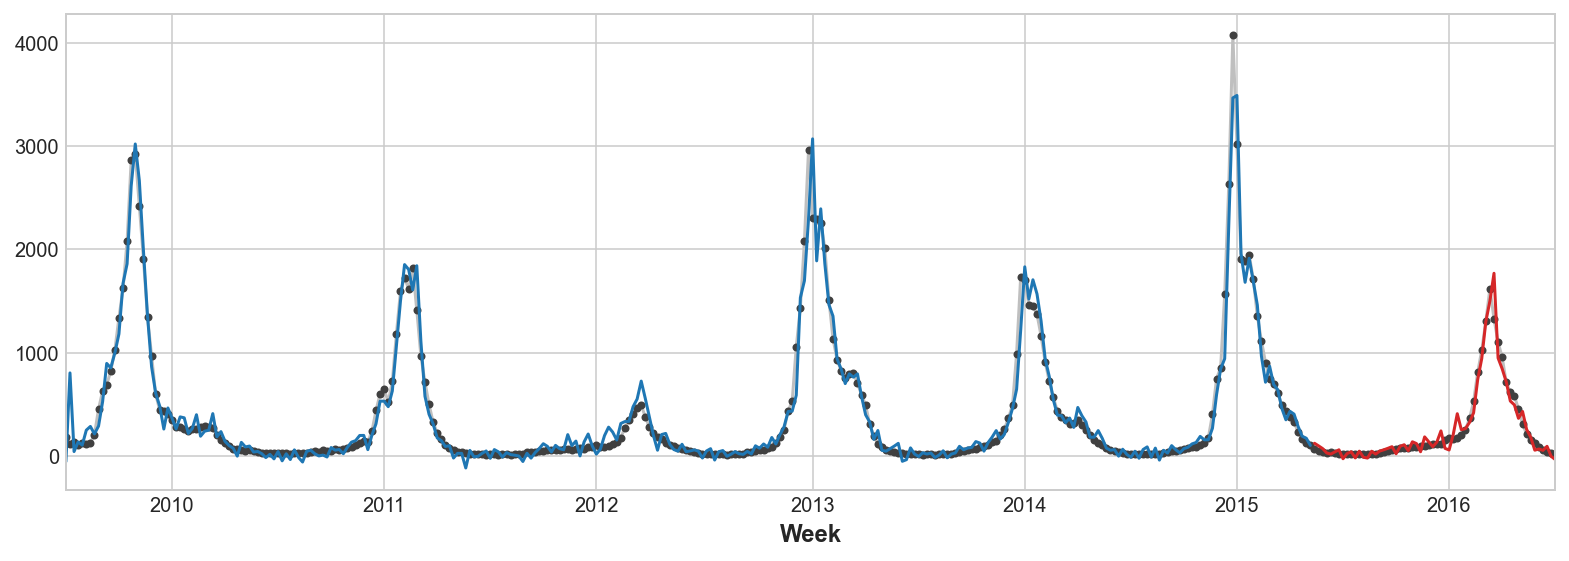

In [31]:
ax = y_train.plot(**plot_params)
ax = y_test.plot(**plot_params)
ax = y_pred.plot(ax = ax)
_ = y_fore.plot(ax = ax, color = 'C3')

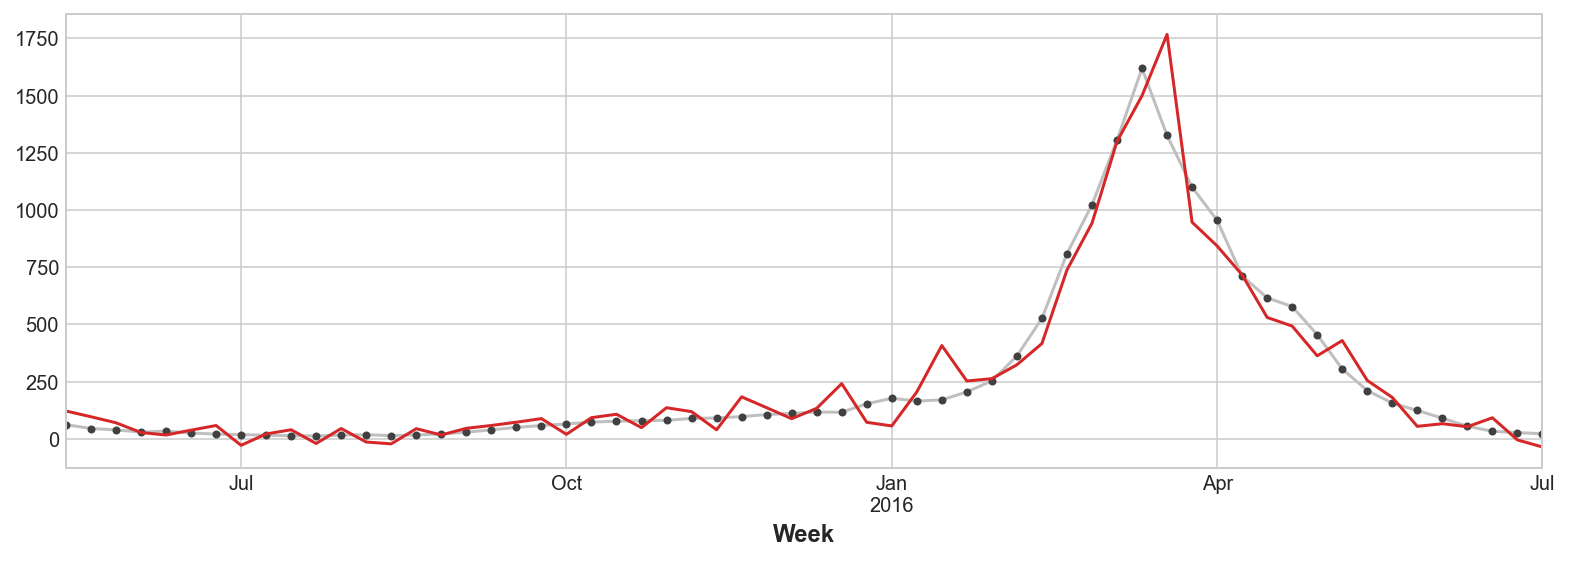

In [32]:
ax = y_test.plot(**plot_params)
_ = y_fore.plot(ax=ax, color = 'C3')

#### 5. Hybrid Models

In [4]:
# extra packages
from xgboost import XGBRegressor

In [5]:
# read data
industries = ['BuildingMaterials', 'FoodAndBeverage']
retail = pd.read_csv('Documents/us-retail-sales.csv',
                    usecols = ['Month'] + industries,
                    parse_dates = ['Month'],
                    index_col = 'Month',
                    ).to_period('D').reindex(columns = industries)

retail = pd.concat({'Sale':retail}, names = [
    None, 'industries'], axis = 1)
retail.head()

Sale                
industries BuildingMaterials FoodAndBeverage
Month                                       
1992-01-01              8964           29589
1992-02-01              9023           28570
1992-03-01             10608           29682
1992-04-01             11630           30228
1992-05-01             12327           31677

In [6]:
# first fit a linear model
y = retail.copy()

# create trend features
dp = DeterministicProcess(
    index = y.index,
    constant = True,
    order = 2,
    drop = True, # drop terms to avoid collinearity
)
X = dp.in_sample()

# split the data index instead of the dataframe index
idx_train, idx_test = train_test_split(
    y.index, test_size = 12 * 4, shuffle = False,
)
X_train, X_test = X.loc[idx_train,:], X.loc[idx_test,:]
y_train, y_test = y.loc[idx_train], y.loc[idx_test]

# for convenience of appendices 5
X1_train = X_train.copy()
X1_test = X_test.copy()
y1_train = y_train.copy()
y1_test = y_test.copy()

# fit trend model 
model = LinearRegression(fit_intercept = False)
model.fit(X_train, y_train)

y_fit = pd.DataFrame(
    model.predict(X_train),
    index = y_train.index,
    columns = y_train.columns,
)
y_pred = pd.DataFrame(
    model.predict(X_test),
    index = y_test.index,
    columns = y_test.columns)

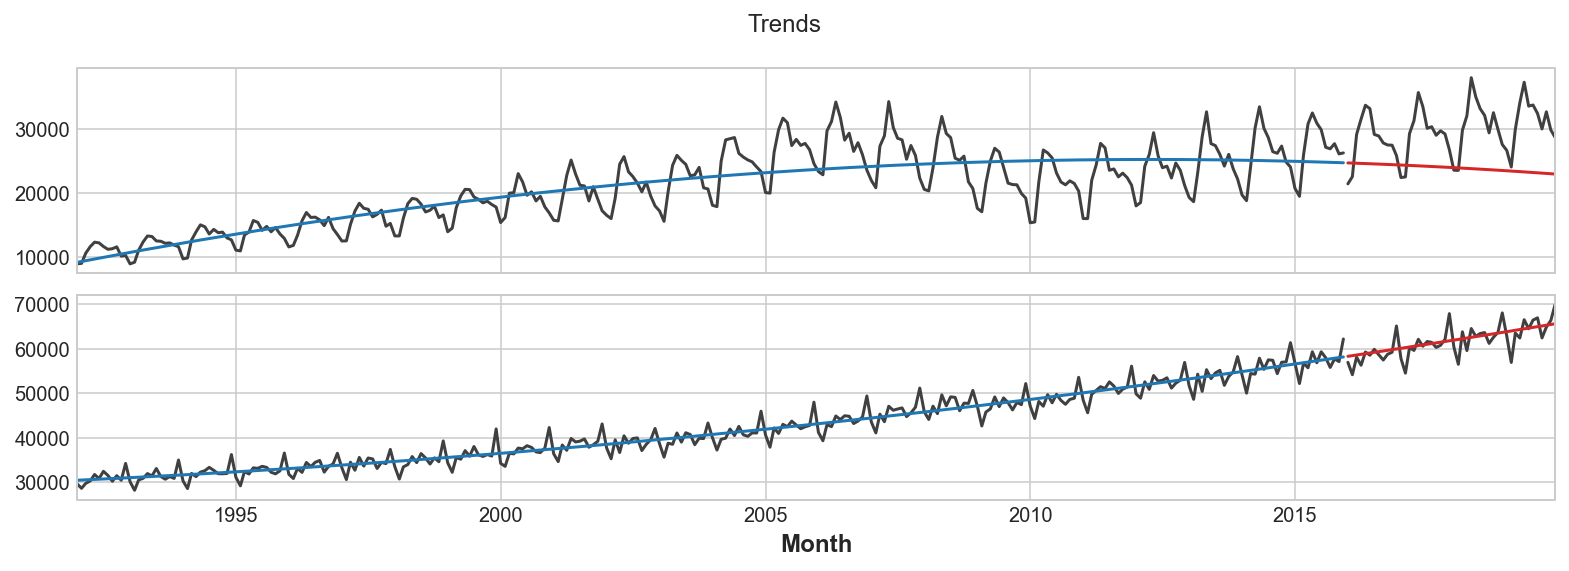

In [7]:
# plot 
axs = y_train.plot(color = '.25', subplots = True, sharex = True)
axs = y_test.plot(color = '.25', subplots = True, sharex = True, ax = axs)
axs = y_fit.plot(color = 'C0', subplots = True, sharex = True, ax = axs)
axs = y_pred.plot(color = 'C3', subplots = True, sharex = True, ax = axs)

for ax in axs: ax.legend([])
_ = plt.suptitle('Trends')

In [8]:
# the 'stack' method converts column labels to row labels,
# pivoting from wide format to long
X = retail.stack()
display(X.head())
y = X.pop('Sale') # grad target series

Sale
Month      industries              
1992-01-01 BuildingMaterials   8964
           FoodAndBeverage    29589
1992-02-01 BuildingMaterials   9023
           FoodAndBeverage    28570
1992-03-01 BuildingMaterials  10608

In [9]:
# Turn row labels into categorical feature columns
# with a label encoding
X = X.reset_index('industries')
for colname in X.select_dtypes(['object',
                               'category']):
    X[colname], _ = X[colname].factorize() # _ stores index name
# or use LabelEncoder from sklearn.preprocessing
# le = LabelEncoder()
# X[colname] = le.fit_transfrom(X[colname])
    
# Label encoding for annual seasonality
X['Month'] = X.index.month # values are 1, 2, ..., 12

# create splits
X_train, X_test = X.loc[idx_train, :], X.loc[idx_test, :]
y_train, y_test = y.loc[idx_train], y.loc[idx_test]

# for convenience of appendices 5
X2_train = X_train.copy()
X2_test = X_test.copy()

In [10]:
# convert the trend preds to long format 
# subtract from original series
# return detrended (residual) series for XGBoost

y_fit = y_fit.stack().squeeze()
y_pred = y_pred.stack().squeeze()

# res
y_res = y_train - y_fit

# train XGBoost on the residuals
xgb = XGBRegressor()
xgb.fit(X_train, y_res)

# add the predicted residuals onto the predicted trends
y_fit_boosted = xgb.predict(X_train) + y_fit 
y_pred_boosted = xgb.predict(X_test) + y_pred

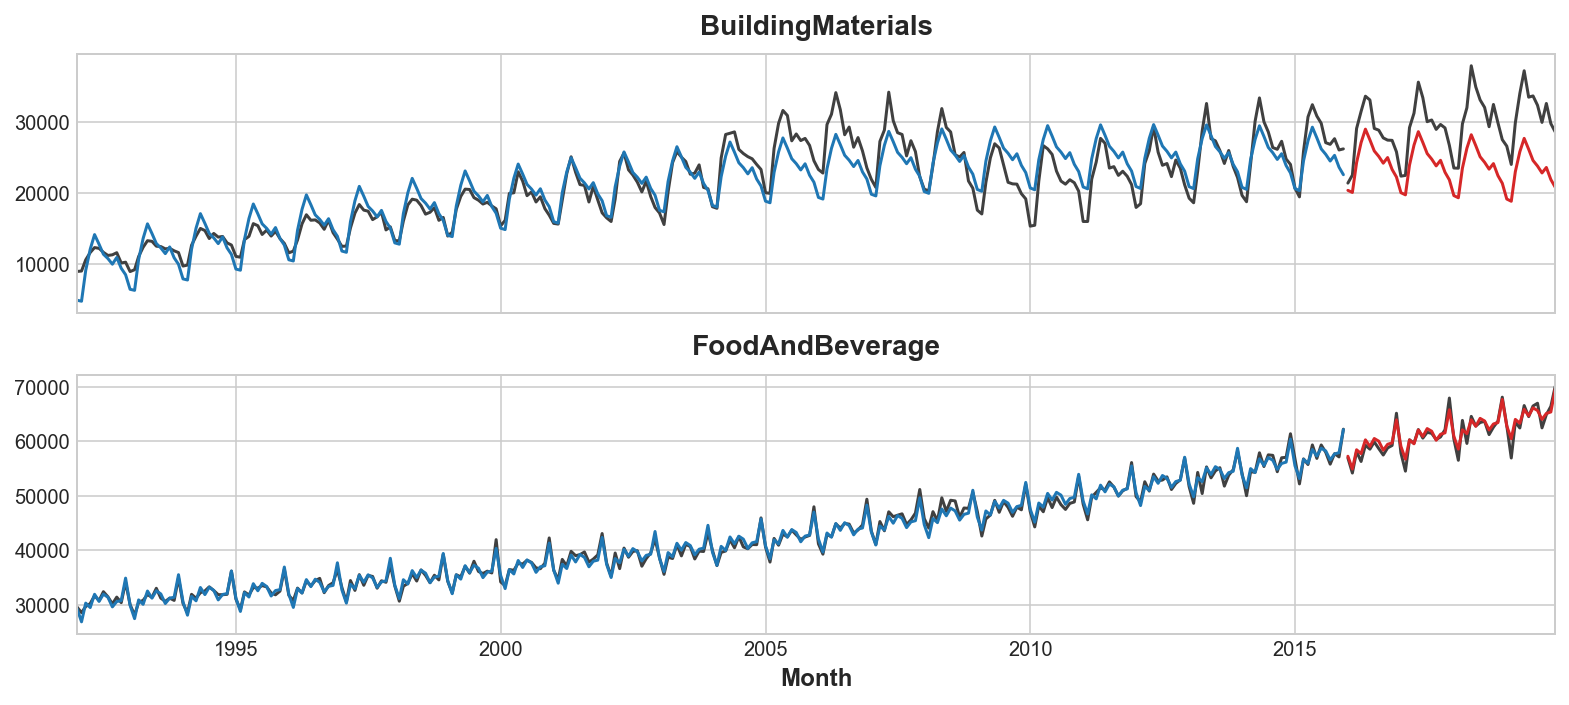

In [11]:
axs = y_train.unstack(['industries']).plot(
    color = '.25', figsize = (11,5), 
    subplots = True, sharex = True,
    title = ['BuildingMaterials', 'FoodAndBeverage'],
)
axs = y_test.unstack(['industries']).plot(
    color = '.25', subplots = True,
    sharex = True, ax = axs)

axs = y_fit_boosted.unstack(['industries']).plot(
    color = 'C0', subplots = True, sharex = True,
    ax = axs,)
axs = y_pred_boosted.unstack(['industries']).plot(
    color = 'C3', subplots = True, sharex = True,
    ax = axs,)

for ax in axs: ax.legend([])
# XGBoost only as good as the trend learned 
# linear regression, in particular for Building Materials,
# which is poorly fit

#### 6. Forecasting with Machine Learning

In [134]:
# transform the series into a dataframe we can use \
# with Machine Learning algorithms

N = 20
ts = pd.Series(
    np.arange(N),
    index = pd.period_range(start = '2010',
                           freq = 'A', periods = N, 
                           name = 'Yes'),
                dtype = pd.Int8Dtype,
)

# Lag Features
X = pd.DataFrame({
    'y_lag_2': ts.shift(2),
    'y_lag_3': ts.shift(3),
    'y_lag_4': ts.shift(4),
    'y_lag_5': ts.shift(5),
    'y_lag_6': ts.shift(6), # 5 lag features
})

# Multi-step targets
y = pd.DataFrame({
    'y_step_3': ts.shift(-2),
    'y_step_2': ts.shift(-1),# 2-step lead time
    'y_step_1': ts, 
})

data = pd.concat({'Targets': y, 'Features': X}, 
                axis = 1)

data.head(10).style.set_properties(['Targets'],
                   **{'background-color': 'LavenderBlush'}) \
.set_properties(['Features'], **{'background-color': 'Lavender'})


###### Example: Flu Trends

In [44]:
def plot_multistep(y, every = 1, ax = None, 
                   palette_kwargs = None):
    palette_kwargs_ = dict(palette = 'husl', 
                         n_colors = 16, desat = None)
    if palette_kwargs is not None:
        palette_kwargs_.update(palette_kwargs)
    palette = sns.color_palette(**palette_kwargs_)
    if ax is None:
        fig, ax = plt.subplots()
    ax.set_prop_cycle(plt.cycler('color', 
                                 palette)) 
    # cycle through colormap? 
    # Yes. may also cycle through 'linestyle' (e.g., -, --,:,-.)  
    for date, preds in y[::every].iterrows():
        preds.index = pd.period_range(start = date,
                         periods = len(preds))
        preds.plot(ax=ax)
    return ax

flu_trends = pd.read_csv('Documents/flu-trends.csv')
flu_trends.set_index(
    pd.PeriodIndex(flu_trends.Week, freq = 'W'),
    inplace = True,
)
flu_trends.drop('Week', axis = 1, inplace = True)

In [41]:
# Prepare target series (weekly office visits for the flu)\
# for multistep forecasting

def make_lags(ts, lags, lead_time = 1):
    return pd.concat({
        f'y_lag_{i}':ts.shift(i)
        for i in range(lead_time, lags+lead_time)
    },axis = 1)

y = flu_trends.FluVisits.copy()
X = make_lags(y, lags = 4).fillna(0.0)

# target series
def make_multistep_target(ts, steps):
    return pd.concat(
    {f'y_step_{i+1}': ts.shift(-i)
    for i in range(steps)},
    axis = 1)

y = make_multistep_target(y, steps = 8).dropna()

# only y keep times for which we have both targets and features, \
# so join by y
y, X = y.align(X, join = 'inner', axis = 0)

# split train & test sets
X_train, X_test, y_train, y_test = train_test_split(
X, y, test_size = 0.25, shuffle = False)

###### <font color = '#909090'>Multi-Output Model</font>

In [42]:
# Multi-Output model e.g., Linear Regression
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

###### <font color = '#909090'>Direct Strategy</font>

In [46]:
# Direct Strategy -- just wrap XGBoost with MultiOutputRegressor
from sklearn.multioutput import MultiOutputRegressor
model = MultiOutputRegressor(XGBRegressor())
model.fit(X_train, y_train)

MultiOutputRegressor(estimator=XGBRegressor(base_score=None, booster=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None,
                                            enable_categorical=False,
                                            gamma=None, gpu_id=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=None,
                                            max_delta_step=None, max_depth=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            n_estimators=100, n_jobs=None,
                                            num_parallel_tree=None,
     

###### <font color = '#909090'> Recursive Strategy </font>

In [ ]:
# code yourself -- pending


###### <font color = '#909090'>DiRec Strategy</font>

In [48]:
from sklearn.multioutput import RegressorChain
model = RegressorChain(XGBRegressor())
model.fit(X_train, y_train)

RegressorChain(base_estimator=XGBRegressor(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           enable_categorical=False, gamma=None,
                                           gpu_id=None, importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate=None,
                                           max_delta_step=None, max_depth=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           n_estimators=100, n_jobs=None,
                                           num_parallel_tree=None,
                                           objective='reg:squa

###### RMSE & Plot

Train RMSE: 33.59
Test RMSE: 572.14


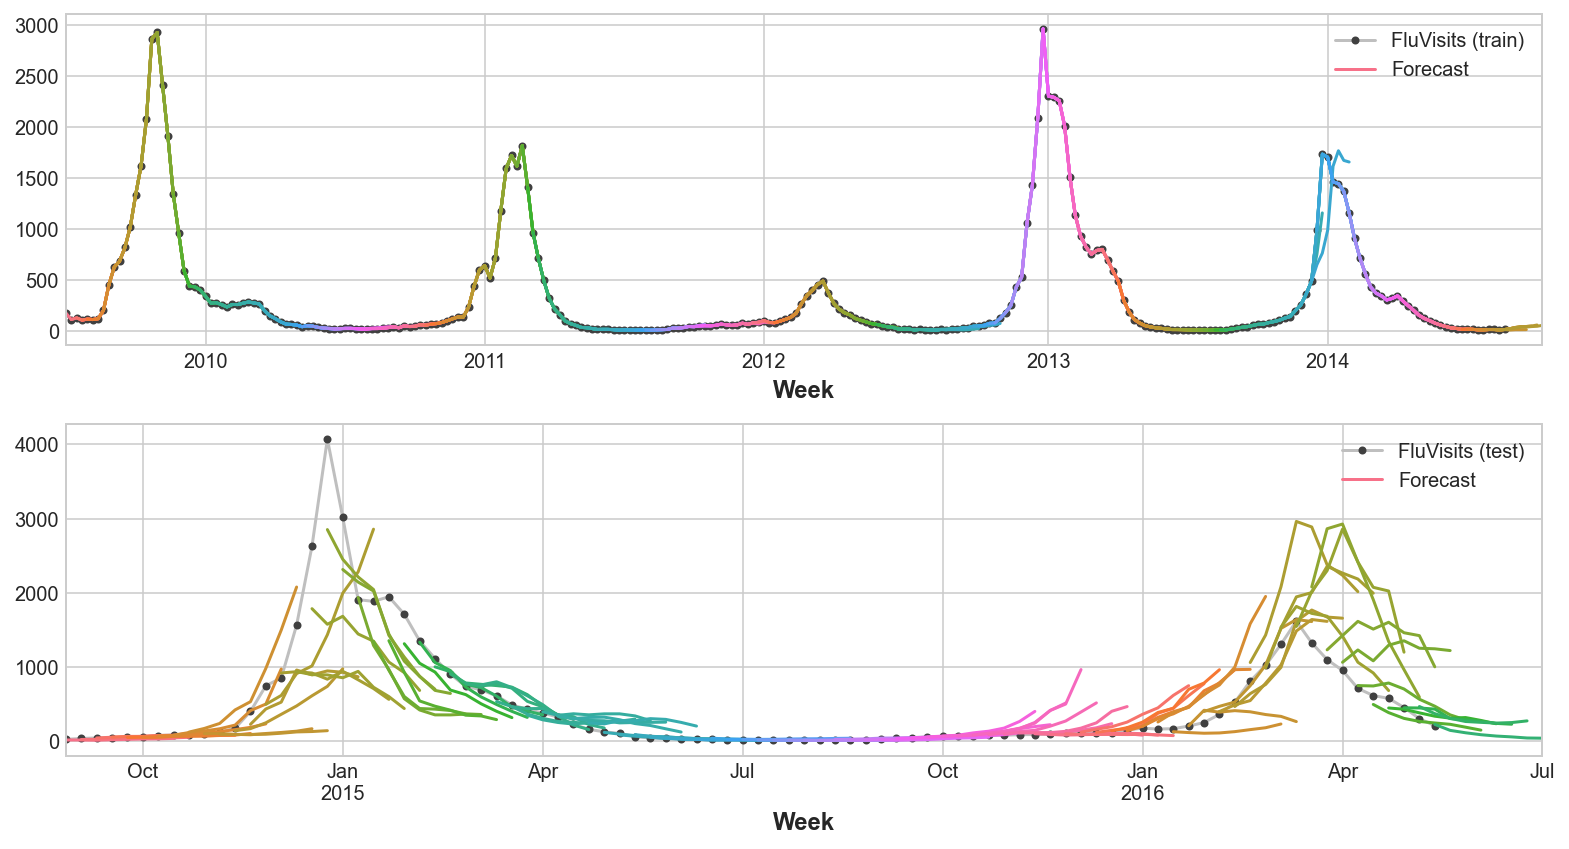

In [49]:
y_fit = pd.DataFrame(model.predict(X_train), 
                    index = X_train.index, 
                    columns = y.columns)
y_pred = pd.DataFrame(model.predict(X_test), 
                    index = X_test.index, 
                    columns = y.columns)

train_rmse = mean_squared_error(y_train, y_fit,
                               squared = False)
test_rmse = mean_squared_error(y_test, y_pred,
                              squared = False)
print((f"Train RMSE: {train_rmse:.2f}\n" f"Test RMSE: {test_rmse:.2f}"))

palette = dict(palette = 'husl', n_colors = 64)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize = (11,6))     
ax1 = flu_trends.FluVisits[y_fit.index].plot(**plot_params, ax=ax1)
ax1 = plot_multistep(y_fit, ax=ax1, palette_kwargs=palette)
_ = ax1.legend(['FluVisits (train)', 'Forecast'])
ax2 = flu_trends.FluVisits[y_pred.index].plot(**plot_params, ax=ax2)
ax2 = plot_multistep(y_pred, ax=ax2, palette_kwargs=palette)
_ = ax2.legend(['FluVisits (test)', 'Forecast'])

#### Appendices

###### Map growth rate

Text(0.5, 1.0, 'GR Plot of Tunnel Traffic')

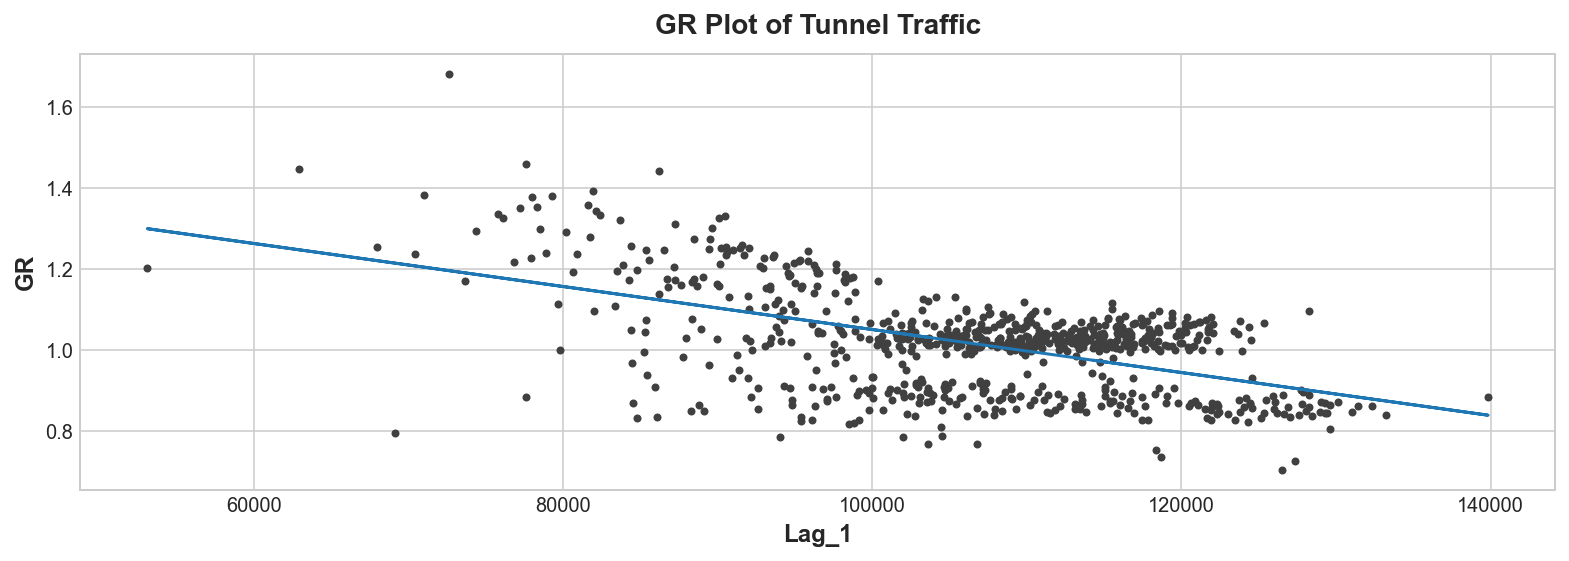

In [57]:
# Map growth rate as percentage change
# model it with an exponential curve

# pct_change, %?, exponential/log
df = tunnel.copy()
df['Lag_1'] = df.NumVehicles.shift(1)
df['GrowthRate'] = np.exp(df.NumVehicles.pct_change())

X = df.loc[:,['Lag_1']]
X.dropna(axis = 0, inplace = True)
y = df.GrowthRate
y, X = y.align(X, join = 'inner', axis = 0)

model = LinearRegression()
model.fit(X, y)

y_pred = pd.Series(model.predict(X), index = X.index)

fig, ax = plt.subplots()
ax.plot(X['Lag_1'], y, '.', color = '.25')
ax.plot(X['Lag_1'], y_pred)
ax.set_ylabel('GR')
ax.set_xlabel('Lag_1')
ax.set_title('GR Plot of Tunnel Traffic')
# Is it correct?

###### Fit trend with splines & Detrending

In [58]:
from pyearth import Earth
from statsmodels.tsa.deterministic import DeterministicProcess
y = tunnel.copy()
dp = DeterministicProcess(
    index = y.index, order = 1)
X = dp.in_sample()

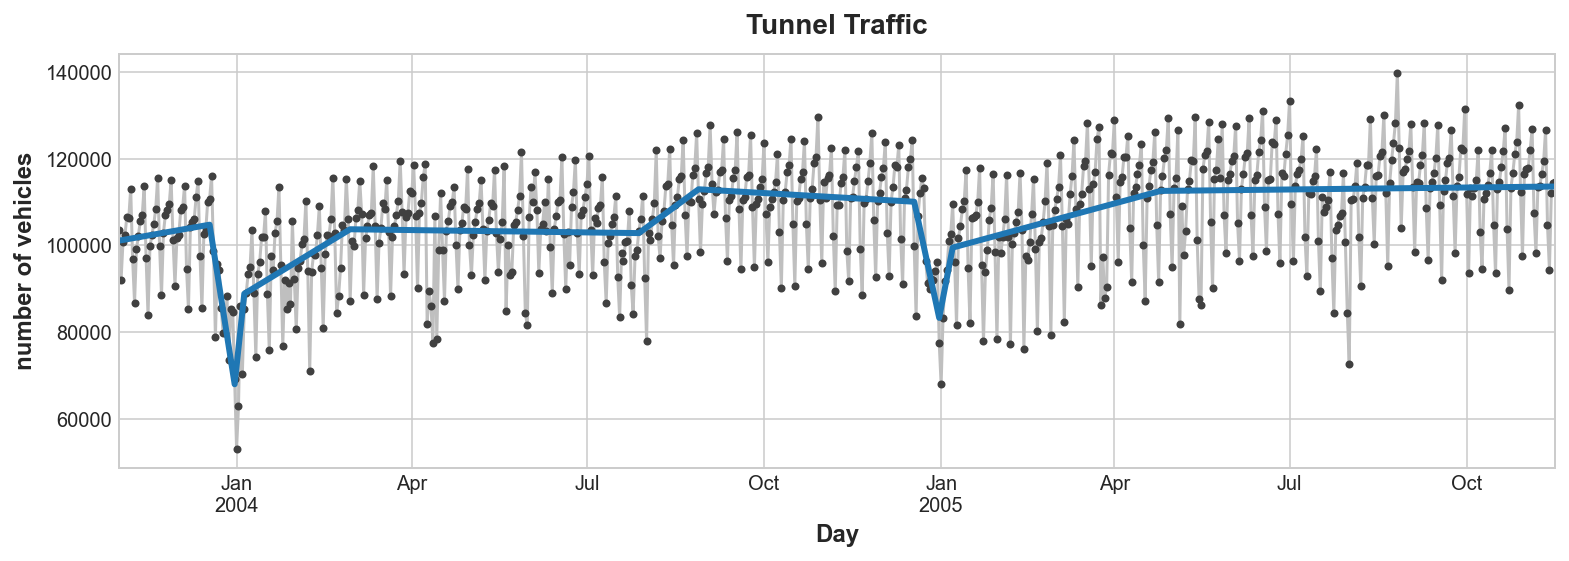

In [59]:
# fit a multivariate adaptive regression splines
model = Earth()
model.fit(X, y)

y_pred = pd.Series(model.predict(X), index = X.index)

ax = y.plot(**plot_params, title = 'Tunnel Traffic',
          ylabel = 'number of vehicles')
ax = y_pred.plot(ax= ax, linewidth = 3, label = 'Trend') 

<AxesSubplot:title={'center':'Detrened Tunnel Traffic'}, xlabel='Day'>

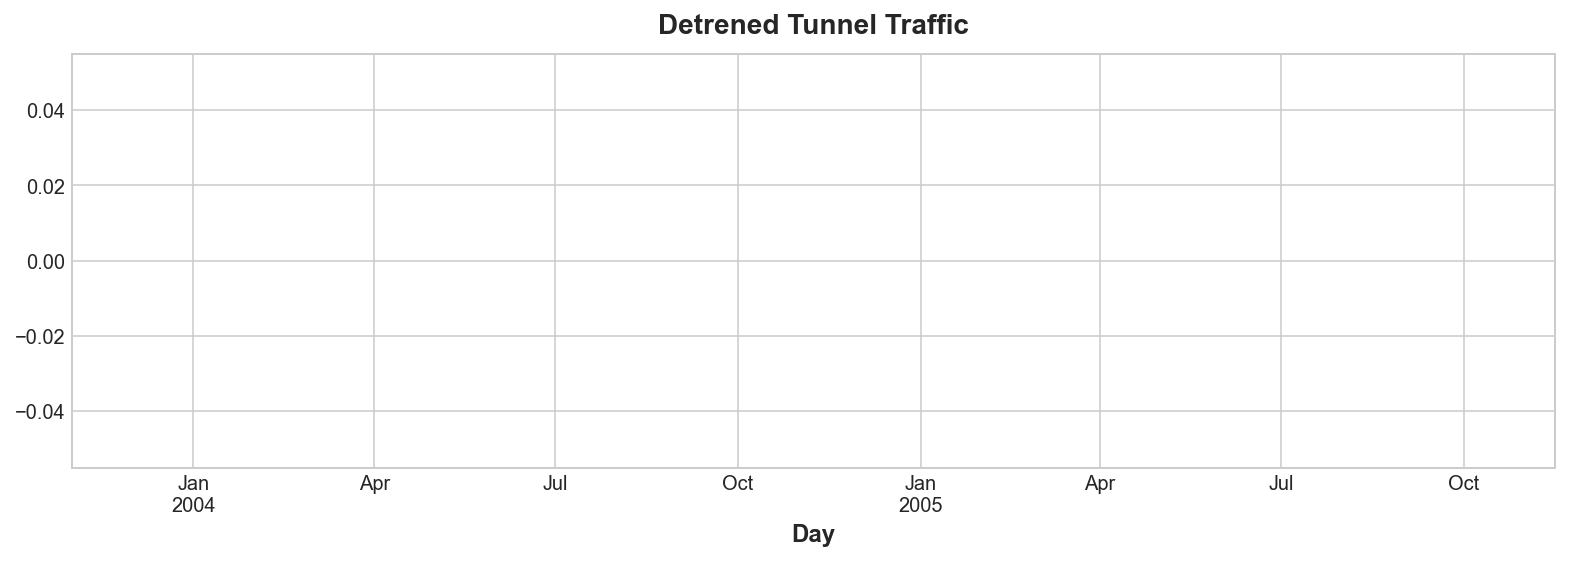

In [60]:
# Detrend to isolate other patterns in a time series
y_detrend = y - y_pred
y_detrend.plot(**plot_params, title = 'Detrened Tunnel Traffic') # no other patterns

###### compute Fourier features

In [61]:
import numpy as np

def fourier_features(index, freq, order):
    time = np.arange(len(index), dtype = np.float32)
    k = 2* np.pi*(1/freq) * time
    features = {}
    for i in range(1, order + 1):
        features.update({
            f"sin_{freq}_{i}": np.sin(i*k),
            f"cos_{freq}_{i}": np.cos(i*k),
        })
    return pd.DataFrame(features, index = index)

###### 5_continued Create a Hybrid combinations from Class

In [12]:
class Hybrid:
    def __init__(self, model_1, model_2):
        self.model_1 = model_1
        self.model_2 = model_2
        self.y_columns = None # store column names 
    # from fit method

In [13]:
def fit(self, X_1, X_2, y):
    self.model_1.fit(X_1, y)
    y_fit = pd.DataFrame(
        self.model_1.predict(X_1),
        index = X_1.index,
        columns = y.columns,
    )
    
    y_resid = y - y_fit
    y_resid = y_resid.stack().squeeze() # wide to long
    
    self.model_2.fit(X_2, y_resid)
    self.y_columns = y.columns
    self.y_fit = y_fit
    self.y_resid = y_resid
    
# Add method to class
Hybrid.fit = fit

In [14]:
def predict(self,X_1, X_2):
    y_pred = pd.DataFrame(
        self.model_1.predict(X_1),
        index = X_1.index,
        columns = self.y_columns)
    
    y_pred = y_pred.stack().squeeze()
    
    y_pred += self.model_2.predict(X_2)
    
    return y_pred.unstack()

Hybrid.predict = predict

In [15]:
# some choices of models
# model_1: 
# from sklearn.linear_model import ElasticNet, Lasso, Ridge

# model_2:
# from sklearn.emsemble import ExtraTreesRegressor, RandomForestRegressor
# from sklearn.neighbors import KNeighborsRegressor
# from sklearn.neural_network import MLPRegressor

model = Hybrid(LinearRegression(),
              XGBRegressor())
model.fit(X1_train, X2_train, y1_train)
y_fit = model.predict(X1_train, X2_train)

y_fit = y_fit.clip(0.0)

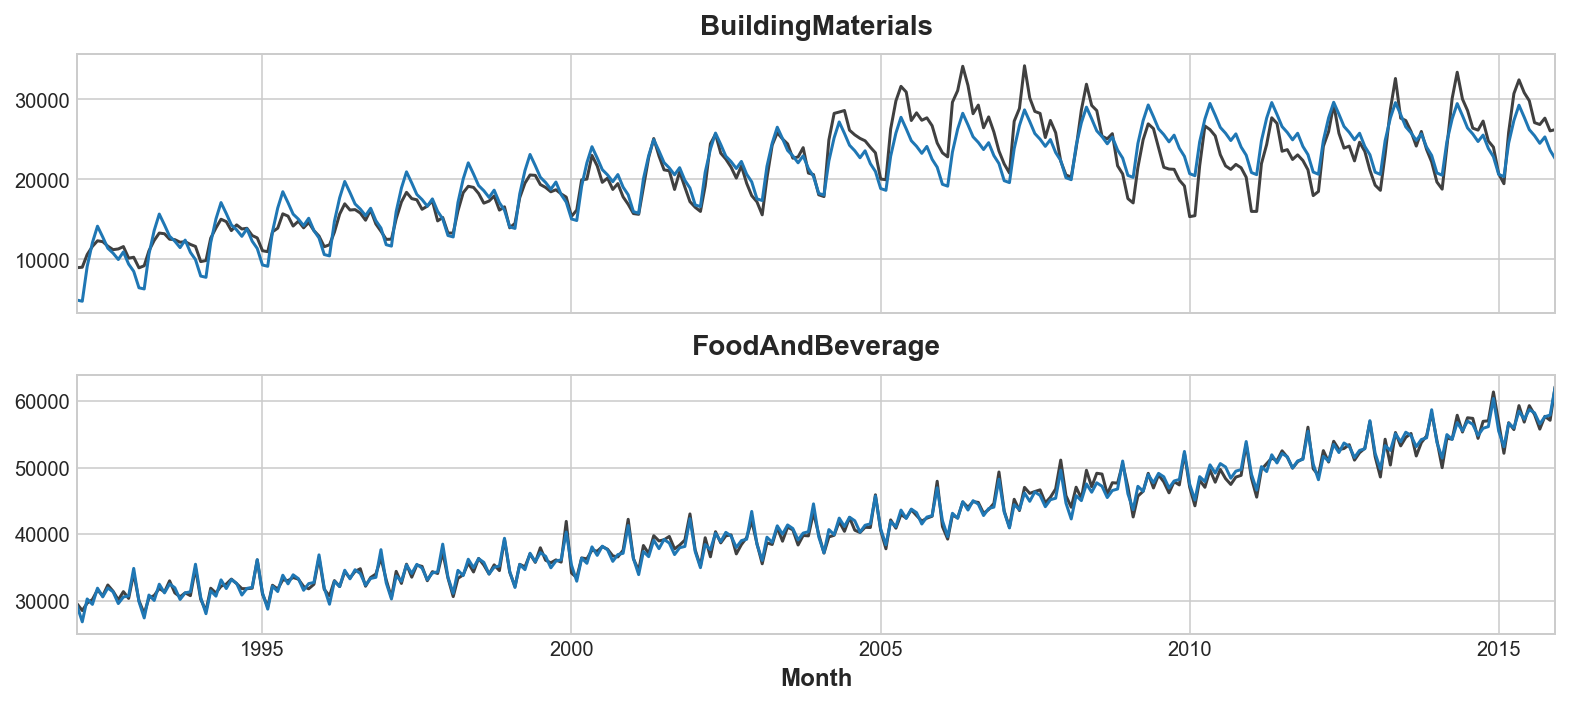

In [17]:
axs = y1_train.plot(
    color = '.25', figsize = (11,5), 
    subplots = True, sharex = True,
    title = ['BuildingMaterials', 'FoodAndBeverage'],
)

axs = y_fit.plot(
    color = 'C0', subplots = True, sharex = True,
    ax = axs,)

for ax in axs: ax.legend([])